In [1]:
!pip install tensorflow
!pip install cuda-python

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import ResNet101
from keras import Model
from keras.layers.experimental import preprocessing
from keras.models import Sequential

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
# import itertools
from PIL import Image

2024-06-30 16:16:25.475438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 16:16:25.475475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 16:16:25.476330: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 16:16:25.481921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
dataset = "../../Smartbin/Dataset/Crawl_dataset/Data_real"
walk_through_dir(dataset)

There are 3 directories and 0 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real'.
There are 0 directories and 4061 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/UnRecycle'.
There are 0 directories and 8402 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Organic'.
There are 0 directories and 7552 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Recycle'.


In [5]:
# Đường dẫn đến thư mục chứa dataset
data_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(data_dir.glob(r'**/*.JPG')) + list(data_dir.glob(r'**/*.jpg')) + list(data_dir.glob(r'**/*.png')) + list(data_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
image_df

,Filepath,Label
0,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
1,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
2,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
3,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
4,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
...,...,...
21150,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21151,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21152,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21153,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle


In [7]:
# random_index = np.random.randint(0, len(image_df), 16)
# print(random_index)
# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
#     ax.set_title(image_df.Label[random_index[i]])
# plt.tight_layout()
# plt.show()

In [8]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [9]:
train_df.shape

(16924, 2)

In [10]:
test_df.shape

(4231, 2)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

In [12]:
import os

# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 13540 validated image filenames belonging to 3 classes.
Found 3384 validated image filenames belonging to 3 classes.
Found 4231 validated image filenames belonging to 3 classes.


In [13]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  #layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

2024-06-30 16:16:28.017703: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 16:16:28.017964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 16:16:28.076514: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [14]:
pretrained_model=tf.keras.applications.resnet.ResNet101(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
)

In [15]:
pretrained_model.trainable = False

In [16]:
# Create checkpoint callback
checkpoint_path = "bags_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [17]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 50,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [18]:
inputs=pretrained_model.inputs
x = resize_and_rescale(inputs)
x=Dense(256,activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)

In [19]:
model=Model(inputs,outputs)

In [20]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=200,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "bag_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/bag_classification/20240630-161637


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


2024-06-30 16:16:42.426606: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-30 16:17:11.528344: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe360e34690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-30 16:17:11.528385: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-06-30 16:17:11.528397: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-30 16:17:11.538507: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719764231.621251 2865322 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


424/424 [==============================] - 366s 785ms/step - loss: 0.1767 - accuracy: 0.9377 - val_loss: 0.0572 - val_accuracy: 0.9799
Epoch 2/200
424/424 [==============================] - 307s 725ms/step - loss: 0.0579 - accuracy: 0.9814 - val_loss: 0.0499 - val_accuracy: 0.9820
Epoch 3/200
424/424 [==============================] - 314s 741ms/step - loss: 0.0353 - accuracy: 0.9876 - val_loss: 0.0488 - val_accuracy: 0.9814
Epoch 4/200
424/424 [==============================] - 320s 755ms/step - loss: 0.0228 - accuracy: 0.9927 - val_loss: 0.0491 - val_accuracy: 0.9829
Epoch 5/200
424/424 [==============================] - 327s 772ms/step - loss: 0.0175 - accuracy: 0.9945 - val_loss: 0.0486 - val_accuracy: 0.9837
Epoch 6/200
424/424 [==============================] - 327s 771ms/step - loss: 0.0124 - accuracy: 0.9961 - val_loss: 0.0487 - val_accuracy: 0.9858
Epoch 7/200
424/424 [==============================] - 306s 721ms/step - loss: 0.0086 - accuracy: 0.9973 - val_loss: 0.0484 - val_

In [21]:
history.history

{'loss': [0.17670851945877075,
  0.05792452394962311,
  0.03530771657824516,
  0.022756114602088928,
  0.01746959425508976,
  0.012415931560099125,
  0.008636650629341602,
  0.00582401268184185,
  0.004223666153848171,
  0.0040012565441429615,
  0.003920708782970905,
  0.0019495368469506502,
  0.0021241973154246807,
  0.004083234816789627,
  0.001507338136434555,
  0.0013451180420815945,
  0.0022253887727856636,
  0.0024015516974031925,
  0.001096893916837871,
  0.0004052605654578656,
  0.0004353812837507576,
  0.003209085436537862,
  0.0030641600023955107,
  0.0024699948262423277,
  0.0013288432965055108,
  0.0002687801024876535,
  0.00033681857166811824,
  0.00010366208152845502,
  9.986673831008375e-05,
  0.006927830167114735,
  0.0007340293377637863,
  0.00034184163087047637,
  0.0001996058417716995,
  0.00012442270235624164,
  0.0007735301624052227,
  0.0011123506119474769,
  0.0034225317649543285,
  0.0005939697148278356,
  0.00020103197311982512,
  0.001808200147934258,
  0.0019

In [22]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.02697
Test Accuracy: 99.15%


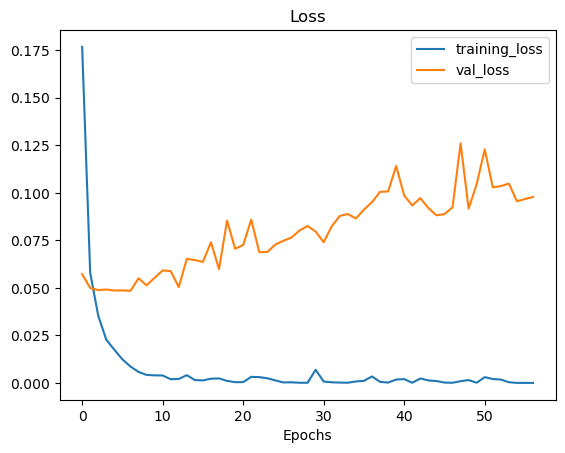

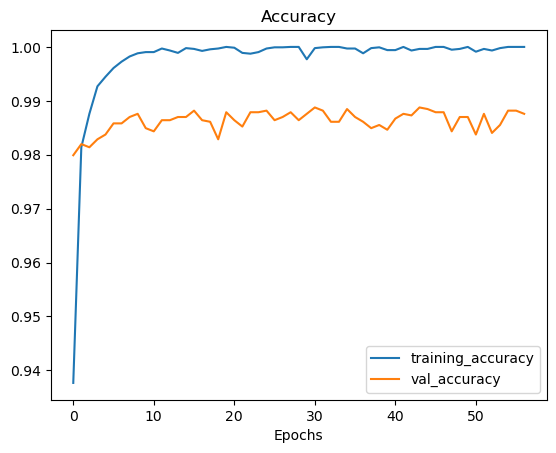

In [23]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [24]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

133/133 [==============================] - 66s 489ms/step
The first 10 predictions: ['UnRecycle', 'Recycle', 'Organic', 'Recycle', 'Recycle', 'Organic', 'Recycle', 'UnRecycle', 'Organic', 'Recycle']


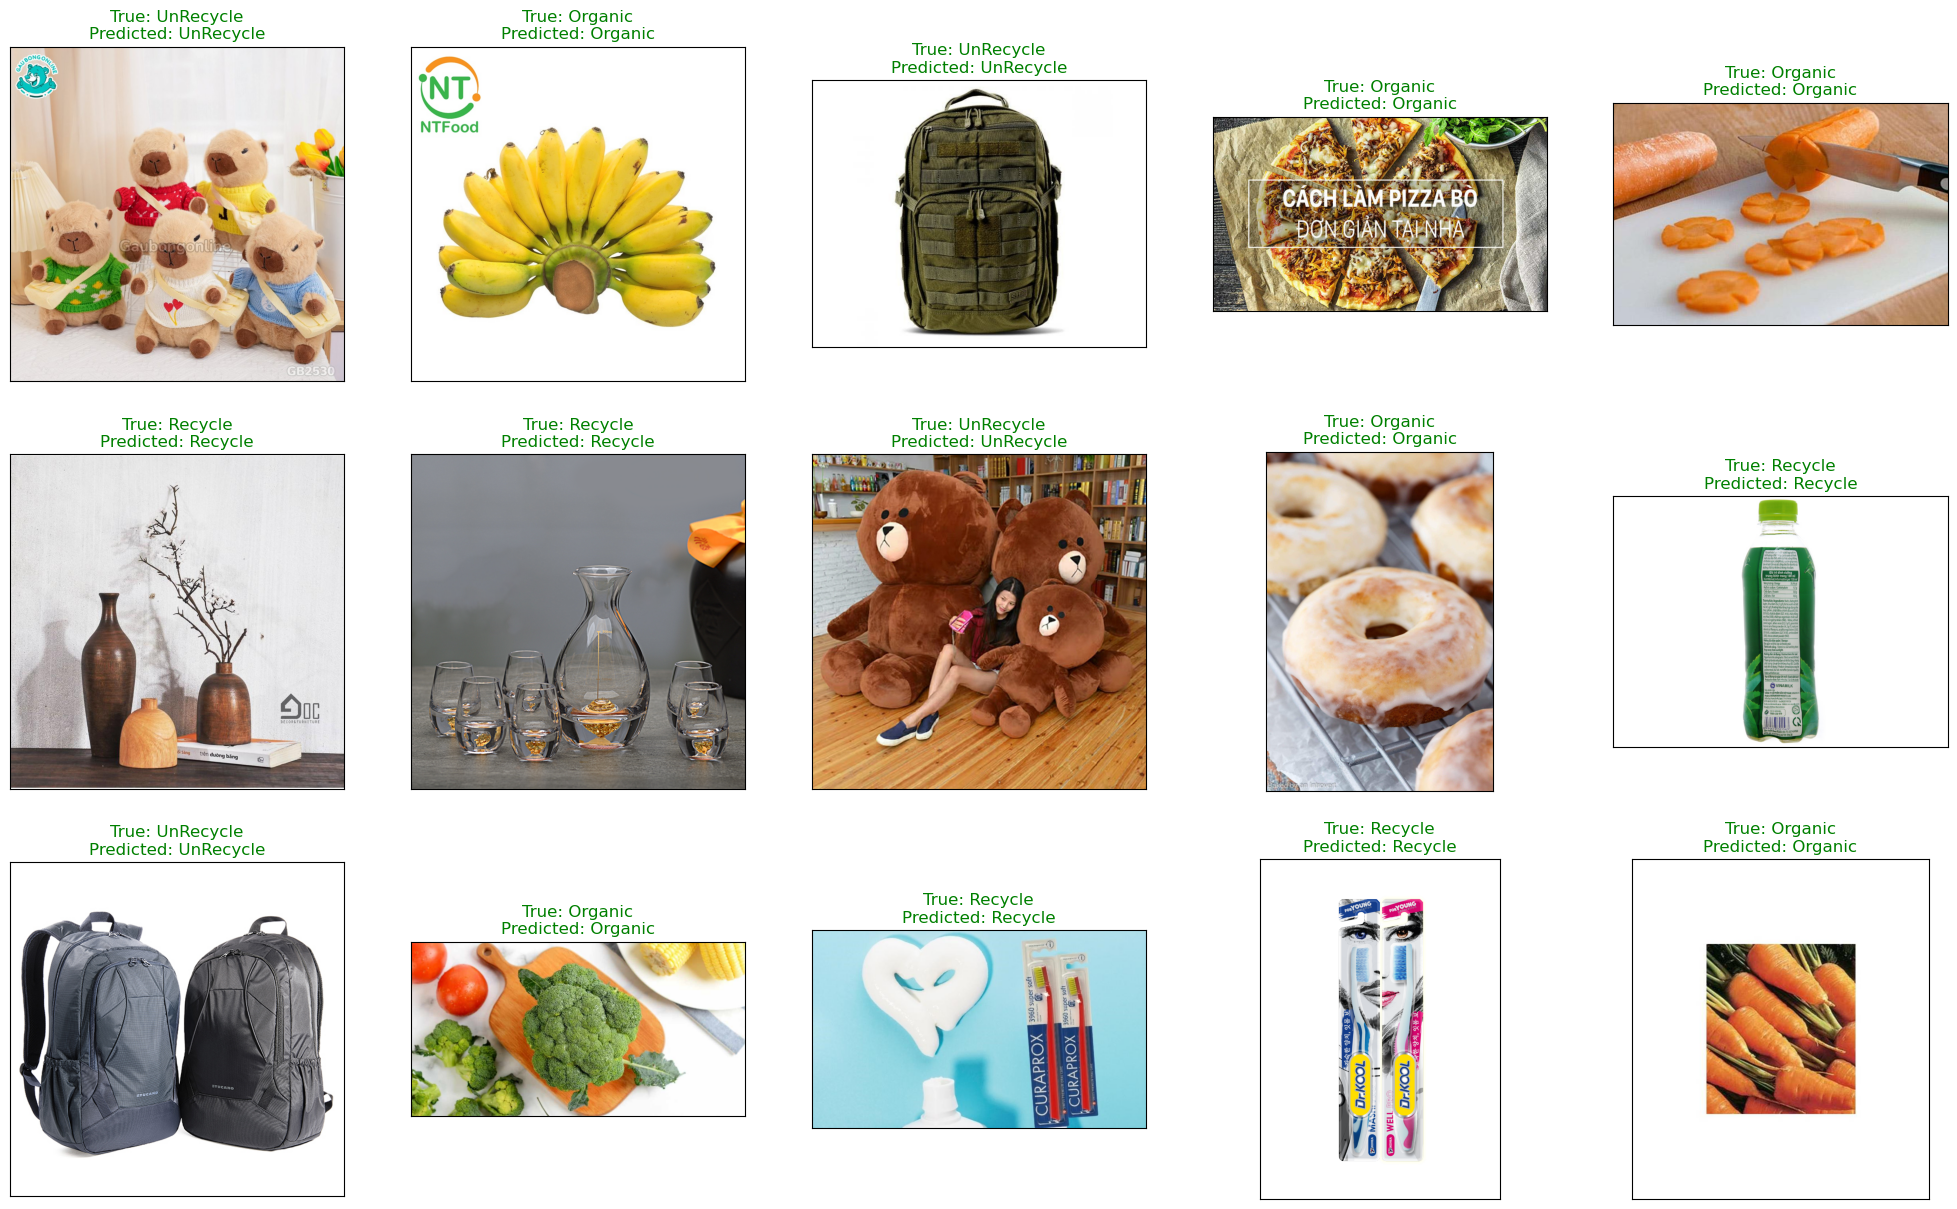

<Figure size 640x480 with 0 Axes>

In [25]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [26]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Organic,0.991051,0.994947,0.992995,1781.000000
Recycle,0.993789,0.987045,0.990405,1621.000000
UnRecycle,0.987995,0.992762,0.990373,829.000000
accuracy,0.991491,0.991491,0.991491,0.991491
macro avg,0.990945,0.991585,0.991258,4231.000000
weighted avg,0.991501,0.991491,0.991489,4231.000000


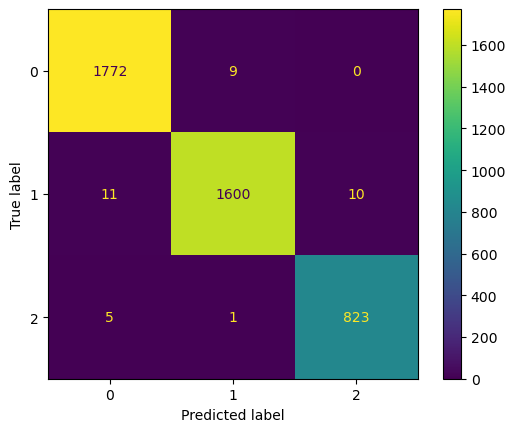

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [28]:
model.save('../Resnet101.h5')

/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model("../Resnet101")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS,  # Enable TensorFlow ops.
]
tflite_model = converter.convert()

OSError: SavedModel file does not exist at: ../Resnet101/{saved_model.pbtxt|saved_model.pb}

In [ ]:
# Lưu mô hình TFLite vào một tập tin
with open("resnet101.tflite", "wb") as f:
    f.write(tflite_model)